# Topic modelling using LDA

## Import libraries

In [1]:
import pythainlp
import gensim

import numpy as np
import pandas as pd
import re
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap.umap_ as umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections
import deepcut

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [10]:
# Sample documents
documents = {'comment':
        ['คุ้มค่า ใช้งานง่ายสุดๆ เหมาะสำหรับคนไม่อยากพกอะไรไว้เยอะ และวางแผนการท่องเที่ยวเป็นอย่างดีเพราะบัตรระบุวันที่จะต้องใช้ ไม่สามารเลื่อนวันได้ และไม่จำเป็นต้องจอง จ่ายเงินสำหรับเข้า nintendo แต่เราต้องไปให้เร็วเพื่อจองเข้า nintendo หลังจากที่เราผ่านเข้าประตูไปแล้ว ในนั้นสวยงามและสนุกสนาน คนเยอะทุกวัน ควรหลีกเลี่ยง เสาร์อาทิตย์และช่วงเทศกาล ไม่งั้นอาจจะต้องรอเล่นเครื่องเล่นหลายชั่วโมง',
         'สั่งซื้อบัตรผ่านuniversal studios japan osaka สะดวกมาก voucherที่ได้รับเป็นqr code สามารถสแกน หรือแสดงให้เจ้าหน้าที่ดูได้เลย การใช้งานไม่ซับซ้อน ราคาถูก ชำระเงินonline ได้ สามารถซื้อบัตรผ่านต่างๆ รวมถึงตั๋วรถไฟได้ด้วย เทียบราคาแล้วไม่แพง แต่สะดวกทึ่ไม่ต้องต่อคิว มีเครดิตklookสะสมอยู่ ทริปหน้าจองผ่านแอพklookอีกแน่นอน',
         'ใครมี่มาโอซาก้ายังไงก็ต้องห้ามพลาด USJ ล่าสุดมีโซนใหม่ Nintendo world ดีงามมากๆเหมือนหลุดออกมาจากเกมเลย ใครเป็นแฟนพันธ์อท้ต้องไปเยือนสักครั้ง ส่วนโซนอื่นๆก็ยังมีเสน่ห์น่าสนใจเหมือนเดิม แนะนำเลยค่ะ ซื้อผ่าน klook ก็รวดเร็วไม่ต้องไปต่อแถวซื้อบัตรข้างหน้าสะดวกมากๆ',
         'สะดวกมากกกก สแกน QR code เข้าปาร์คได้เลย แนะนำให้สแกน register กับแอพ USJ ก่อนไป พอเข้าไปจะได้กดจองคิว Nintendo world ได้เลย ไปวันธรรมดาไม่ต้องซื้อ express pass ก็ได้ เก็บเครื่องเล่นหลักได้เกือบครบ Flying Dinosaur คือที่สุดดด ห้ามพลาดจริงๆ',
         'จองตั๋วเข้า Universe Studios Japan in Osaka ผ่าน Kook ได้ตั๋วแบบ electronics ช่วยประหยัดเวลา ไปต่อแถวซื้อตั๋วที่ด้านหน้าทางเข้า แค่โชว์ จากในโทรศัพท์ ก็ สามารถ เข้าไปชมด้านในได้เลย ช่วยประหยัดเวลาได้มาก โดยเฉพาะในวันที่คนเยอะมากๆ',
         'วันนั้นดูพยากรณ์อากาศก่อนเข้าไป วันจองบอกว่าฝนจะตกและก็ตกทั้งวะนจริงๆเราเลยแชทคุยกับKlook เพื่อขอเลื่อนตั๋วหรือยกเลิกเพื่อของใหม่ พนักงานก็ใจดีให้ความสะดวกในการยกเลิกตั๋วเพื่อทำการจองใหม่ ในวันที่อากาศดี เลยอยากรีริวการให้การบริการของพนักงานkoolk ครับผม ซื้อบัตรจากkoolk ใช้เที่ยวUSJ ได้สบายๆเลยครับ',
         'สะดวกมากๆๆ แค่ใช้มือถือแสดงก้อเข้าได้เลย ไม่ต้องเสียเวลาต่อคิวซื้อตั๋ว แป๊บเดียวด้อได้เข้าไปเล่นแล้ว แนะนำสะดวกจริง',
         'ง่าย สะดวก แค่ scan จากมือถือก็สามารถเข้าได้เลย แต่แนะนำว่าถ้าต้องการเล่นทั้ง Harry , Mario , Nintendo , Minions ควรซื้อพาสเพิ่ม ไม่งั้นควรมาแต่เช้าประมาณ 8.00 AM เพราะตอนนี้คิวรอเล่นแต่ละที่คอยนานมาก',
         'จองผ่าน klook ไม่ต้องแลกรับบัตรที่ด้านหน้า สามารถโชว์ภาพถ่ายคิวอาร์โค้ดสแกนผ่านประตูได้เลย ขอบอกว่าแถวซื้อตั๋วยาวมากๆ แต่เราเข้าได้เลย สะดวกสุดๆ อย่าลืมเลือกประเภทบัตรวันให้ตรงวันใช้งาน เราไม่จำเป็นต้องใช้วันที่เราเลือกตอนจอง เพียงแต่ต้องมาใช้ให้ตรงตามประเภทบัตรที่จอง(หมดอายุตามเงื่อนไขที่ระบุในบัตร) ปล.ควรซื้อแบบ2วันไปเลย เพราะลูกจะติดใจ',
         'ใช้ง่ายสะดวกสุดๆ แต่เอาคิวอาร์โค้ดไปแสกนหน้าทางเข้าได้เลย โดยไม่ต้องไปแลกตั๋วใดๆ เครื่องเล่นเยอะจนเลือกไม่ถูก แนะนำให้รีบไปก่อนสวนสนุกเปิด เพราะคนเยอะมาก และให้อยู่ยาวจนสวนสนุกปิด ก็สามารถเล่นเครื่องเล่นได้เยอะมากแล้ว คุ้มค่ามาก ไปวันธรรมดาคนจะน้อยกว่าเสาร์อาทิตย์ โซนมาริโอ้สวยมาก อย่างกับไปอยู่อีกโลกนึง ใครไป usj ต้องเข้าโซนมาริโอ้นะ แนะนำ!!!',
         'ใน app บอกเวลาเปิด 9.30 น. ถ้าแพลนจะเข้า Nintendo โดยไม่ได้ซื้อบัตร express ควรไปให้ถึง Park ประมาณ 8.00 น. เพื่อจะให้เข้าไปได้โดยไม่ต้องลุ้น Lottery Park เปิดจริงๆเวลา 8.30 น. และคนเยอะมากๆ',
         'เครื่องเล่นใช้เวลานานมาก ของกินน้อยต้องต่คิวนาน แย่งกัน ไม่คุ้มค่าบัตรเพราะทำอะไรไม่ได้นอกจากยืนดู ดีสุด คือถ่ายรูปกับลูกโลกหน้าประตูทางเข้า',
         'บัตรเลือกวันไม่ได้ และ ยังไม่ได้ รับเงินคืน คุยแล้ว ก็ ไม่คืนเงินให้ ทำให้ แผนการ ท่องเที่ยว ล่ม ทั้งโรงแรม และ บัตรเข้ายูเวอร์แซล ใช้ไม่ได้ แม้สักอัน ทำให้ การมาเที่ยว แย่มาก ต้องรีบกลับทันที ซื้อ 22/ตอนเย็นที่ปิดแล้ว แทนที่จะเปลี่ยนวันให้ ก็ ไม่เปลี่ยนให้ แล้ว ทำให้ เสียเวลาในการไปเที่ยว ซื้อบัตร ของ klook กว่า 3 ครั้ง ทุกครั้ง ทำให้ การเดินทาง ล่มตลอด ไม่เคย ประสบผลสำเร็จ ในการ ท่องเที่ยวสักครั้ง มันเปลี่ยนวัน ไม่ได้ และ เปลี่ยน ไม่คืนเงิน ทุกกรณี ทั้งที่ ระบบผิดพลาดตลอด',
         'พลาด Super nintendo world .. ไม่มีข้อบ่งชี้ชัดเจนว่าเป็นการจองตั๋วแยกต่างหากสำหรับ supermario world',
         'USJ แออัดเกินไปแม้แต่ในวันธรรมดา เราต้องใช้เวลาเกือบหนึ่งชั่วโมงต่อคิวในการนั่งทุกครั้ง ไม่ใช่ประสบการณ์ที่สนุกสนานอย่างแน่นอน',
         'ซื้อตั๋วจากKlook ก่อนที่จะไปเข้าusj จะลัดขั้นตอนการไปยืนซื้อตั๋วหน้างานซึ่งใช้เวลานาน ดังนั้นควรซื้อตั๋วผ่านklook ก่อนและจะได้รหัสคิวอาร์โค้ดไปแสดงซึ่งอยู่ในมือถือของเราไปแสดงเพื่อscanเข้างานได้อย่างสะดวกและเร็ว คุ้มค่าคุ้มเวลาจริงๆ',
         'ใช้งานสะดวกมากค่ะ ไม่ต้องไปแลกตั๋วที่เคาเตอร์ สามารถสแกนตั๋วผ่านโทรศัพท์ที่หน้าทางเข้าได้เลย ไม่จำเป็นต้องพกกระดาษให้ยุ่งยาก วันที่ไปแดดร้อนแรงมาก สามารถนำน้ำขวดขนาด 500 ml หรือข้าวปั้นเล็กๆ เข้าได้นะคะ เพราะอาหารข้างในค่อนข้างแพง แต่ถ้าชอบความน่ารัก อยากถ่ายร฿ป ก็เข้าไปซื้อกินข้างในได้ค่ะ แต่รสชาติงั้นๆ',
         'ใช้งานง่าย เเสกนปุ้บเข้าได้ปั๊บ รวดเร็ว เป็นการมาครั้งที่สองของเรา เพราะอยากลองเข้าโซนมาริโอ้กับลองเครื่องเล่นโนบิตะ ก็ถือว่าโอเคค่ะ วันที่ไปฝนตกหนักเลยไม่ค่อยจอย เพราะมันเปียกเเฉะไปหมด เเล้วเเต่ดวงจริงๆว่าไปจะเจอฝนไหม เพราะจองล่วงหน้าไว้นานช่วงโกลเด้นวีค',
         'QR Code ใช้ง่ายครับ ไปถึงหน้า USJ ตอน 8.00 AM. คนเยอะแล้ว มีหลายทางเข้า แนะให้ไปตอนเช้าไปรอเลย ตอนได้เข้าพวกเราเดินไป Harrypotter Zone ก่อนเลย ไปนั่งเครื่องเล่น แบบไม่ต้องรอ (เพราะทุกคนไป Mario Zone กันหมด^^) เราได้เล่น 2 รอบสบายๆ และใช้ App USJ จองคิว Mario Zone ได้เข้าตอน 11.00 AM. สนุกมากครับ',
         'คุ้มค่า ใช้งานง่ายสุดๆ เหมาะสำหรับคนไม่อยากพกอะไรไว้เยอะ และวางแผนการท่องเที่ยวเป็นอย่างดีเพราะบัตรระบุวันที่จะต้องใช้ ไม่สามารเลื่อนวันได้ และไม่จำเป็นต้องจอง จ่ายเงินสำหรับเข้า nintendo แต่เราต้องไปให้เร็วเพื่อจองเข้า nintendo หลังจากที่เราผ่านเข้าประตูไปแล้ว ในนั้นสวยงามและสนุกสนาน คนเยอะทุกวัน ควรหลีกเลี่ยง เสาร์อาทิตย์และช่วงเทศกาล ไม่งั้นอาจจะต้องรอเล่นเครื่องเล่นหลายชั่วโมง',
         'ดี รวดเร็ว เสียดายที่ express ขายหมดเร็วมากในช่วงที่ไป เลยต้องเสียเวลาไป 2 วันในการเก็บให้ครบ',
         'จองบัตรง่าย สะดวกรวดเร็ว สามารถเปิดจากมือถือได้ ไม่ต้องต่อคิวซื้อตั๋ว สะดวกมากค่ะ',
         'ไม่ต้องพิมพ์ตั๋วเป็นกระดาษ สามารถเปิด qr code จากมือถือสแกนเข้าผ่านประตูสวนสนุกได้เลย สะดวกมากๆ',
         'ใช้งานง่ายและสะดวกมากๆค่ะ ได้รับการคอนเฟิร์มไวมาก ซื้อทั้งหมด 6 ใบ ใช้งานได้ปกติดีทุกคน พอเข้าสวนสนุกไปก็เชื่อมบัตรลงในแอพของสวนสนุก เพื่อกดจองรอบเข้ามาริโอ้ แนะนำเลยค่ะ เราซื้อล่วงหน้าประมาณ 4 วัน ใช้งานได้ไม่มีปัญหา ครบถ้วน']}

# doc to pandas df
df = pd.DataFrame(documents)
df.tail()


,comment
19,คุ้มค่า ใช้งานง่ายสุดๆ เหมาะสำหรับคนไม่อยากพกอ...
20,ดี รวดเร็ว เสียดายที่ express ขายหมดเร็วมากในช...
21,จองบัตรง่าย สะดวกรวดเร็ว สามารถเปิดจากมือถือได...
22,ไม่ต้องพิมพ์ตั๋วเป็นกระดาษ สามารถเปิด qr code ...
23,ใช้งานง่ายและสะดวกมากๆค่ะ ได้รับการคอนเฟิร์มไว...


In [11]:
stop_word = list(pythainlp.corpus.thai_stopwords())
rm_word = removed_words = ['',' ','    ','\n', '(', ')', '..', '^^', '/', 'ดด', 'ๆ', '^', '!', 'กกก', 'กก','ๆๆ', '!!!', 'มี่']
screenword = stop_word + rm_word

def tokenize_n_space(sentence):
    merged = ''
    words = pythainlp.word_tokenize( str(sentence), engine = 'newmm')
    for i in words :
        if i not in screenword :
            merged = merged + ',' + i
    return merged[1:]

In [12]:
df['tokenized'] = df['comment'].apply(lambda x: tokenize_n_space(x))
df.tail()

,comment,tokenized
19,คุ้มค่า ใช้งานง่ายสุดๆ เหมาะสำหรับคนไม่อยากพกอ...,"คุ้มค่า,ใช้งาน,เหมาะสำหรับ,คน,พก,วางแผน,การท่อ..."
20,ดี รวดเร็ว เสียดายที่ express ขายหมดเร็วมากในช...,"ดี,เสียดาย,express,ขาย,เสียเวลา,2"
21,จองบัตรง่าย สะดวกรวดเร็ว สามารถเปิดจากมือถือได...,"จอง,บัตร,สะดวก,มือถือ,ไม่ต้อง,คิว,ซื้อ,ตั๋ว,สะดวก"
22,ไม่ต้องพิมพ์ตั๋วเป็นกระดาษ สามารถเปิด qr code ...,"ไม่ต้อง,พิมพ์,ตั๋ว,กระดาษ,qr,code,มือถือ,สแกน,..."
23,ใช้งานง่ายและสะดวกมากๆค่ะ ได้รับการคอนเฟิร์มไว...,"ใช้งาน,สะดวก,คอนเฟิร์ม,ไว,ซื้อ,6,ใบ,ใช้งาน,ปกต..."


In [13]:
doc = df['tokenized'].to_list()
texts = [ [i for i in dc.split(',')] for dc in doc ]
dictionary = gensim.corpora.Dictionary(texts)

print(dictionary.token2id.keys())

dict_keys(['nintendo', 'การท่องเที่ยว', 'คน', 'คุ้มค่า', 'จอง', 'จำเป็นต้อง', 'จ่าย', 'ชั่วโมง', 'ดี', 'ที่จะ', 'บัตร', 'ประตู', 'พก', 'มาร', 'รอ', 'ระบุ', 'วางแผน', 'สนุกสนาน', 'สวยงาม', 'สา', 'สำหรับ', 'หลังจากที่', 'หลีกเลี่ยง', 'อาทิตย์', 'เครื่องเล่น', 'เงิน', 'เทศกาล', 'เลื่อน', 'เล่น', 'เสาร์', 'เหมาะสำหรับ', 'ใช้งาน', 'ไม่งั้น', 'code', 'japan', 'klook', 'online', 'osaka', 'qr', 'studios', 'universal', 'voucher', 'การใช้งาน', 'คิว', 'ชำระเงิน', 'ซับซ้อน', 'ซื้อ', 'ดู', 'ตั๋วรถไฟ', 'ทริป', 'ทึ่', 'ราคา', 'สะดวก', 'สะสม', 'สั่งซื้อ', 'สแกน', 'หน้า', 'เครดิต', 'เจ้าหน้าที่', 'เทียบ', 'แน่นอน', 'แพง', 'แอพ', 'ไม่ต้อง', 'Nintendo', 'USJ', 'world', 'ก้า', 'ข้างหน้า', 'ซา', 'ดีงาม', 'ต้องห้าม', 'น่าสนใจ', 'พลาด', 'พันธ์', 'มาจาก', 'มีเสน่ห์', 'สักครั้ง', 'หลุด', 'อท้', 'เกม', 'เยือน', 'เหมือน', 'เหมือนเดิม', 'แถว', 'แนะนำ', 'แฟน', 'โซน', 'โอ', 'Dinosaur', 'Flying', 'QR', 'express', 'pass', 'register', 'กด', 'ธรรมดา', 'ปาร์ค', 'หลัก', 'ห้าม', 'เข้าไป', 'Japan', 'Kook', 'Osaka', 'Studio

In [14]:
gensim_corpus = [ dictionary.doc2bow(tx, allow_update = True) for tx in texts ]
word_frq = [ [ (dictionary[ides], frq) for ides, frq in coup ] for coup in gensim_corpus ]

## Topic Modeling using LDA

In [15]:
num_topic = 3
chunksize = 4000 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 50
eval_number = 1 # more number, more compute time spending

# Make index to word dictionary
temp = dictionary[0]
id2word = dictionary.id2token

%time
model = gensim.models.LdaModel( corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, alpha='auto', eta='auto'
                               , iterations=iterations, num_topics=num_topic, passes=passes, eval_every=eval_number )

Wall time: 0 ns


In [16]:
import pyLDAvis.gensim
#visualize result
pyLDAvis.gensim.prepare(model, gensim_corpus, dictionary)  

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.062681  0.080658       1        1  46.236966
2     -0.104437  0.011545       2        1  34.067178
1      0.041756 -0.092203       3        1  19.695856, topic_info=            Term       Freq      Total Category  logprob  loglift
112         ตั๋ว  10.000000  10.000000  Default  30.0000  30.0000
46          ซื้อ  14.000000  14.000000  Default  29.0000  29.0000
24   เครื่องเล่น   5.000000   5.000000  Default  28.0000  28.0000
10          บัตร  11.000000  11.000000  Default  27.0000  27.0000
190           น.   2.000000   2.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
192         เวลา   0.727509   1.936477   Topic3  -5.1548   0.6458
113      ทางเข้า   0.727507   4.024504   Topic3  -5.1548  -0.0858
100       เข้าไป   0.727494   4.825530   Topic3  -5.1549  -0.2673
65           USJ   0.727486   4.636502   Topic3  -5.1549  -0.2274
199          ยืน   0.727483   1.936484   Topic3  -5.1549   0.6457

[181 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
146       1  0.984066         
291       2  0.998573        .
307       1  0.718969        4
147       1  0.382944     8.00
147       2  0.382944     8.00
...     ...       ...      ...
32        1  0.364881  ไม่งั้น
32        2  0.729762  ไม่งั้น
63        1  0.609962  ไม่ต้อง
63        2  0.243985  ไม่ต้อง
63        3  0.121992  ไม่ต้อง

[187 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [17]:
model.show_topic(0)

[('ซื้อ', 0.035744715),
 ('ตั๋ว', 0.033251535),
 ('สะดวก', 0.030755118),
 ('บัตร', 0.023275513),
 ('จอง', 0.020781577),
 ('ไม่ต้อง', 0.015793473),
 ('', 0.015791906),
 ('คิว', 0.015790308),
 ('ใช้งาน', 0.013301443),
 ('มือถือ', 0.0132987825)]

In [18]:
model.show_topic(1)

[('บัตร', 0.027417844),
 ('ซื้อ', 0.023082042),
 ('น.', 0.014428176),
 ('world', 0.014427537),
 ('ดี', 0.010105831),
 ('Park', 0.010099689),
 ('ไม่ต้อง', 0.010099598),
 ('พลาด', 0.010098802),
 ('Nintendo', 0.0100987675),
 ('express', 0.010098624)]

In [19]:
model.show_topic(2)

[('จอง', 0.022702606),
 ('เครื่องเล่น', 0.022699863),
 ('คน', 0.022695564),
 ('รอ', 0.013426135),
 ('เล่น', 0.013425994),
 ('คิว', 0.0134218605),
 ('USJ', 0.013415325),
 ('nintendo', 0.013403728),
 ('แนะนำ', 0.010325366),
 ('ไม่ต้อง', 0.010322404)]

In [20]:
df['topics'] = df['tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][0])
df['score'] = df['tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][1])
df

,comment,tokenized,topics,score
0,คุ้มค่า ใช้งานง่ายสุดๆ เหมาะสำหรับคนไม่อยากพกอ...,"คุ้มค่า,ใช้งาน,เหมาะสำหรับ,คน,พก,วางแผน,การท่อ...",2,0.997576
1,สั่งซื้อบัตรผ่านuniversal studios japan osaka ...,"สั่งซื้อ,บัตร,universal,studios,japan,osaka,สะ...",0,0.998075
2,ใครมี่มาโอซาก้ายังไงก็ต้องห้ามพลาด USJ ล่าสุดม...,"โอ,ซา,ก้า,ต้องห้าม,พลาด,USJ,โซน,Nintendo,world...",1,0.997138
3,สะดวกมากกกก สแกน QR code เข้าปาร์คได้เลย แนะนำ...,"สะดวก,สแกน,QR,code,ปาร์ค,แนะนำ,สแกน,register,แ...",2,0.996772
4,จองตั๋วเข้า Universe Studios Japan in Osaka ผ่...,"จองตั๋ว,Universe,Studios,Japan,in,Osaka,Kook,ต...",0,0.997038
5,วันนั้นดูพยากรณ์อากาศก่อนเข้าไป วันจองบอกว่าฝน...,"ดู,พยากรณ์อากาศ,เข้าไป,จอง,บอ,ฝน,ตก,ตก,วะ,น,แช...",0,0.998126
6,สะดวกมากๆๆ แค่ใช้มือถือแสดงก้อเข้าได้เลย ไม่ต้...,"สะดวก,มือถือ,ก้อ,ไม่ต้อง,เสียเวลา,คิว,ซื้อ,ตั๋...",0,0.994942
7,ง่าย สะดวก แค่ scan จากมือถือก็สามารถเข้าได้เล...,"สะดวก,scan,มือถือ,แนะนำ,ต้องการ,เล่น,Harry,,,M...",0,0.997366
8,จองผ่าน klook ไม่ต้องแลกรับบัตรที่ด้านหน้า สาม...,"จอง,klook,ไม่ต้อง,แล,กรับ,บัตร,ด้านหน้า,โชว์,ภ...",0,0.998304
9,ใช้ง่ายสะดวกสุดๆ แต่เอาคิวอาร์โค้ดไปแสกนหน้าทา...,"สะดวก,คิว,อาร์,โค้ด,แส,กน,หน้า,ทางเข้า,ไม่ต้อง...",2,0.997576


# Document Clustering

In [21]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model
model = hub.load(module_url)

df.tail()

,comment,tokenized,topics,score
19,คุ้มค่า ใช้งานง่ายสุดๆ เหมาะสำหรับคนไม่อยากพกอ...,"คุ้มค่า,ใช้งาน,เหมาะสำหรับ,คน,พก,วางแผน,การท่อ...",2,0.997576
20,ดี รวดเร็ว เสียดายที่ express ขายหมดเร็วมากในช...,"ดี,เสียดาย,express,ขาย,เสียเวลา,2",1,0.984990
21,จองบัตรง่าย สะดวกรวดเร็ว สามารถเปิดจากมือถือได...,"จอง,บัตร,สะดวก,มือถือ,ไม่ต้อง,คิว,ซื้อ,ตั๋ว,สะดวก",0,0.992171
22,ไม่ต้องพิมพ์ตั๋วเป็นกระดาษ สามารถเปิด qr code ...,"ไม่ต้อง,พิมพ์,ตั๋ว,กระดาษ,qr,code,มือถือ,สแกน,...",0,0.993578
23,ใช้งานง่ายและสะดวกมากๆค่ะ ได้รับการคอนเฟิร์มไว...,"ใช้งาน,สะดวก,คอนเฟิร์ม,ไว,ซื้อ,6,ใบ,ใช้งาน,ปกต...",0,0.997265


In [22]:
embed_comments_array = model(df['comment'].values).numpy() 
embed_comments_array

array([[ 0.08083383, -0.01499236, -0.04746435, ..., -0.00234903,
         0.0325636 ,  0.08454169],
       [-0.04334426, -0.05394441,  0.0012633 , ..., -0.0268915 ,
        -0.0121308 , -0.0331042 ],
       [ 0.08335681, -0.02201189, -0.02743049, ..., -0.05694462,
        -0.01264745,  0.05446358],
       ...,
       [ 0.00687447, -0.0752992 , -0.06879501, ..., -0.10824914,
        -0.00354809, -0.04024323],
       [-0.00093583, -0.07062346, -0.01570117, ..., -0.04077922,
         0.01433854, -0.00230974],
       [ 0.01964425,  0.03263445, -0.08469508, ..., -0.03186082,
        -0.00510273,  0.00326312]], dtype=float32)

In [23]:
reducer = umap.UMAP(random_state=42,n_components=20)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

### K-means

d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

Text(0, 0.5, 'WCSS')

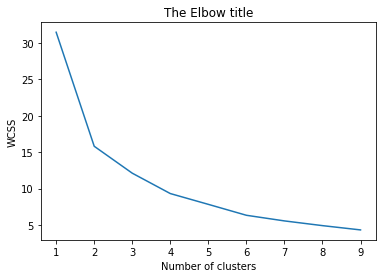

In [24]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10

for i in range(1, max_k):
    kmeans = KMeans(n_clusters=i)# n_init=10)
    kmeans.fit(umap_embed_comments_array)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    number_clusters = range(1, max_k)

plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=2, silhouette score=0.397
k=3, silhouette score=0.321
k=4, silhouette score=0.298


d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=5, silhouette score=0.309
k=6, silhouette score=0.311
k=7, silhouette score=0.289


d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=8, silhouette score=0.241
k=9, silhouette score=0.240


d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


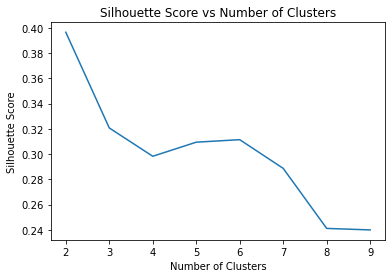

The best number of clusters is 2 with a silhouette score of 0.397


In [25]:
from sklearn.metrics import silhouette_score

# calculate silhouette score for each k
silhouette_scores = []
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k)#, n_init=10)
    kmeans.fit(umap_embed_comments_array)
    score = silhouette_score(umap_embed_comments_array, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"k={k}, silhouette score={score:.3f}")

# plot silhouette scores
plt.plot(range(2, max_k), silhouette_scores)
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

# find the best number of clusters
best_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"The best number of clusters is {best_k} with a silhouette score of {max(silhouette_scores):.3f}")


In [26]:
#run kmeans with no. of clusters you see fit the most
k = 2
kmeans = KMeans(n_clusters = k) #n_init=10)
kmeans.fit(umap_embed_comments_array)
df['KMeans ID'] = kmeans.labels_

d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [27]:
#merge all reviews of each cluster into one big sentence
df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])

for i in range(0, k):
    row = []
    row.append(i)
    row.append(df['comment'][df['KMeans ID'] == i].to_string())
    df_kmeans.loc[len(df_kmeans)] = row

In [28]:
df_kmeans

,KMeans ID,texts
0,0,1 สั่งซื้อบัตรผ่านuniversal studios japan ...
1,1,0 คุ้มค่า ใช้งานง่ายสุดๆ เหมาะสำหรับคนไม่อ...


In [29]:
#create regex compiler for removal of a character you don't want
special_characters = "/[!@#$%^&*']/g"
specialchar_pattern = re.compile(special_characters)

In [30]:
#create regex compiler for removal of any emoji
emoji_pattern = re.compile("["
u"\U0001F600-\U0001F64F" # emoticons
u"\U0001F300-\U0001F5FF" # symbols & pictographs
u"\U0001F680-\U0001F6FF" # transport & map symbols
u"\U0001F1E0-\U0001F1FF" # flags (iOS)
"]+", flags=re.UNICODE)

#create regex compiler for removal of digit
number_pattern = re.compile("[0-9]")
#create regex compiler for removal of white space
space_pattern = re.compile("\s+")
#create regex compiler for removal of .
dot_pattern = re.compile(r"\.+")
#create regex compiler for removal of \
backslash_pattern = re.compile(r"\\+")

In [31]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['',' ','    ','\n', '(', ')', '..', '^^', '/', 'ดด', 'ๆ', '^', '!', 'กกก', 'กก','ๆๆ', '!!!', 'มี่']

screening_words = stopwords + removed_words

new_words = {'คุ้มค่า','โอซาก้า','ล่าสุด', 'ปุ๊ปปั๊บ','เคาเตอร์', 'เเสกน', 'ผ่าน', 'บอก', 'ห้ามพลาด', 'ผิดพลาด'}

words = new_words.union(thai_words())
custom_dictionary_trie = Trie(words)

In [32]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization
def tokenize_to_list(sentence):
    merged = []
    words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)#, custom_dict=custom_dictionary_trie)

    for word in words:
        if word not in screening_words:
            merged.append(word)
    return merged

In [33]:
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x:collections.Counter(x).most_common())

In [34]:
df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,สั่งซื้อบัตรผ่านuniversalstudiosjapanosakaจองต...,"[สั่งซื้อ, บัตร, universalstudiosjapanosaka, จ...","[(บัตร, 4), (จอง, 3), (สะดวก, 3), (ไม่ต้อง, 3)..."
1,1,คุ้มค่าใช้งานง่ายสุดๆเหมาะสำหรับคนไม่อยากพกอใค...,"[คุ้มค่า, ใช้งาน, เหมาะสำหรับ, คน, พก, อ, โอซา...","[(ใช้งาน, 4), (สะดวก, 4), (USJ, 3), (คุ้มค่า, ..."


In [35]:
#show texts_count of each cluster
df_kmeans['texts_count'][0]

[('บัตร', 4),
 ('จอง', 3),
 ('สะดวก', 3),
 ('ไม่ต้อง', 3),
 ('ตั๋ว', 3),
 ('มือถือ', 2),
 ('สั่งซื้อ', 1),
 ('universalstudiosjapanosaka', 1),
 ('จองตั๋ว', 1),
 ('UniverseStudiosJapaninOsaka', 1),
 ('ผ่', 1),
 ('ดู', 1),
 ('พยากรณ์อากาศ', 1),
 ('เข้าไป', 1),
 ('บอ', 1),
 ('ฝน', 1),
 ('ก้อ', 1),
 ('ต้', 1),
 ('klook', 1),
 ('แล', 1),
 ('กรับ', 1),
 ('ด้านหน้า', 1),
 ('สาม', 1),
 ('เลือก', 1),
 ('รับเงิน', 1),
 ('คืน', 1),
 ('คุ', 1),
 ('ซื้อ', 1),
 ('Klook', 1),
 ('ก่อนที่จะ', 1),
 ('usj', 1),
 ('ลัด', 1),
 ('ต', 1),
 ('ใช้งาน', 1),
 ('แลก', 1),
 ('เคาเตอร์', 1),
 ('ได', 1),
 ('พิมพ์', 1),
 ('กระดาษ', 1),
 ('qrcode', 1)]

In [36]:
df_kmeans['texts_count'][1]

[('ใช้งาน', 4),
 ('สะดวก', 4),
 ('USJ', 3),
 ('คุ้มค่า', 2),
 ('เหมาะสำหรับ', 2),
 ('คน', 2),
 ('พก', 2),
 ('อ', 2),
 ('คิว', 2),
 ('หน้า', 2),
 ('โอซาก้า', 1),
 ('ห้ามพลาด', 1),
 ('ล่า', 1),
 ('สุ', 1),
 ('ดม', 1),
 ('สแกน', 1),
 ('QRcode', 1),
 ('ปาร์ค', 1),
 ('แนะนำ', 1),
 ('scan', 1),
 ('มือถือ', 1),
 ('เล', 1),
 ('อาร์', 1),
 ('โค้ด', 1),
 ('แส', 1),
 ('กน', 1),
 ('ทา', 1),
 ('app', 1),
 ('เวลาเปิด', 1),
 ('น', 1),
 ('แพลน', 1),
 ('Ninte', 1),
 ('เครื่องเล่น', 1),
 ('ใช้เวลานาน', 1),
 ('ของกิน', 1),
 ('ต่', 1),
 ('นา', 1),
 ('พลาด', 1),
 ('Supernintendoworld', 1),
 ('ข้อบ่งชี้', 1),
 ('ชัด', 1),
 ('แออัด', 1),
 ('เกินไป', 1),
 ('ธรรมดา', 1),
 ('เวล', 1),
 ('เเสกน', 1),
 ('ปุ้บ', 1),
 ('ปั๊บ', 1),
 ('กา', 1),
 ('QRCode', 1),
 ('ตอน', 1),
 ('AM', 1),
 ('ดี', 1),
 ('เสียดาย', 1),
 ('express', 1),
 ('ขาย', 1),
 ('ช', 1),
 ('คอนเฟิร์ม', 1),
 ('ไว', 1)]

In [37]:
# show top key word of each cluster

top_n_words = 10
for i in range(0, len(df_kmeans)):
    print(f"Cluster ID : {i}\n")
    print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_n_words]}\n")

Cluster ID : 0

Most common words include : [('บัตร', 4), ('จอง', 3), ('สะดวก', 3), ('ไม่ต้อง', 3), ('ตั๋ว', 3), ('มือถือ', 2), ('สั่งซื้อ', 1), ('universalstudiosjapanosaka', 1), ('จองตั๋ว', 1), ('UniverseStudiosJapaninOsaka', 1)]

Cluster ID : 1

Most common words include : [('ใช้งาน', 4), ('สะดวก', 4), ('USJ', 3), ('คุ้มค่า', 2), ('เหมาะสำหรับ', 2), ('คน', 2), ('พก', 2), ('อ', 2), ('คิว', 2), ('หน้า', 2)]



### Cosine similarity

In [38]:
#clustering using agglomorative clustering
knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(
linkage="average", connectivity=knn_graph, n_clusters=10, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [39]:
#merge all reviews of each cluster into one big sentence
df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])
for i in range(0, k):
    row = []
    row.append(i)
    row.append(str(df['comment'][df['Agglomerative ID'] == i].tolist()))
    df_Agglomerative.loc[len(df_Agglomerative)] = row

In [40]:

#clean and tokenize sentences. count the occurences of each word
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x:
collections.Counter(x).most_common())

In [41]:
#show top keywords of each cluster
top_N_words = 10
for i in range(0, len(df_Agglomerative)):
    print(f"Cluster ID : {i}\n")
    print(f"Most common words include :{list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include :[('ซื้อ', 14), ('บัตร', 12), ('จอง', 11), ('คน', 9), ('ตั๋ว', 9), ("','", 8), ('เล่น', 6), ('เครื่องเล่น', 6), ('ไม่ต้อง', 6), ('สะดวก', 6)]

Cluster ID : 1

Most common words include :[('สะดวก', 5), ('มือถือ', 3), ('ไม่ต้อง', 3), ('ตั๋ว', 3), ('คิว', 2), ('ซื้อ', 2), ("','", 2), ("['", 1), ('ก้อ', 1), ('เสียเวลา', 1)]

